In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb


In [2]:
df = pd.read_csv(r'../Final Data/Final_Data.csv')
df.head()

,date,wheat_price,fertilizer_idx,avg_temp,drought_idx,cpi,commodity_imp_idx,commodity_exp_idx,flour_price,corn_price,crude_oil_price
0,1990-01-01,3.71,114.4,-1.218474,15.3,127.5,92.5,95.2,0.253,105.900513,22.86
1,1990-02-01,3.56,120.1,-1.965352,14.6,128.0,92.7,94.6,0.249,106.294167,22.11
2,1990-03-01,3.48,119.6,4.222106,11.2,128.6,92.4,94.8,0.252,109.837318,20.39
3,1990-04-01,3.49,119.1,9.391660,8.0,128.9,91.6,95.1,0.251,118.498337,18.43
4,1990-05-01,3.40,115.8,13.738063,7.1,129.1,91.2,95.3,0.254,121.254097,18.20


In [3]:
wheat_price = pd.read_csv(r'../Cleaned Data/Wheat_Price_FRED_clean.csv')
wheat_price = wheat_price.rename(columns={"PWHEAMTUSDM": "Wheat_Price"})
wheat_price

,observation_date,Wheat_Price
0,1990-01-01,167.918579
1,1990-02-01,160.937271
2,1990-03-01,156.528030
3,1990-04-01,159.467529
4,1990-05-01,149.179291
...,...,...
418,2024-11-01,185.734787
419,2024-12-01,185.794351
420,2025-01-01,190.629642
421,2025-02-01,190.102642


In [4]:
df = pd.merge(df, wheat_price[['observation_date', 'Wheat_Price']], left_on='date', right_on='observation_date', how='left').drop(['observation_date','wheat_price'], axis=1).rename(columns={'Wheat_Price': 'wheat_price'})
df.head(50)

,date,fertilizer_idx,avg_temp,drought_idx,cpi,commodity_imp_idx,commodity_exp_idx,flour_price,corn_price,crude_oil_price,wheat_price
0,1990-01-01,114.4,-1.218474,15.3,127.5,92.5,95.2,0.253,105.900513,22.86,167.918579
1,1990-02-01,120.1,-1.965352,14.6,128.0,92.7,94.6,0.249,106.294167,22.11,160.937271
2,1990-03-01,119.6,4.222106,11.2,128.6,92.4,94.8,0.252,109.837318,20.39,156.528030
3,1990-04-01,119.1,9.391660,8.0,128.9,91.6,95.1,0.251,118.498337,18.43,159.467529
4,1990-05-01,115.8,13.738063,7.1,129.1,91.2,95.3,0.254,121.254097,18.20,149.179291
5,1990-06-01,112.4,19.995775,7.3,129.9,90.8,95.1,0.259,120.073067,16.70,135.584137
6,1990-07-01,113.1,21.674213,5.3,130.5,90.5,95.3,0.260,114.955193,18.45,124.928474
7,1990-08-01,115.0,20.938868,3.5,131.6,93.3,95.4,0.255,109.837318,27.31,116.844856
8,1990-09-01,121.4,17.300278,4.8,132.5,96.5,95.8,0.249,102.357361,33.51,114.272812
9,1990-10-01,127.1,9.544056,3.7,133.4,99.3,96.6,0.244,99.995270,36.04,114.640244


In [5]:
df['date'] = pd.to_datetime(df['date'])
exclude_cols = ['date', 'avg_temp', 'drought_idx']
cols_to_logret = [col for col in df.columns if col not in exclude_cols]
logret_df = df[['date']].copy()
for col in cols_to_logret:
    logret_df[col + '_logret'] = (np.log(df[col]) - np.log(df[col].shift(1)))*100

logret_df['avg_temp'] = df['avg_temp']
logret_df['drought_idx'] = df['drought_idx']

logret_df = logret_df.dropna()

In [6]:
logret_df['wheat_price_logret_future'] = logret_df['wheat_price_logret'].shift(-1)
logret_df = logret_df.dropna()
month_df = logret_df[['date','wheat_price_logret']]
print(month_df.head(100))

          date  wheat_price_logret
1   1990-02-01           -4.246455
2   1990-03-01           -2.777957
3   1990-04-01            1.860522
4   1990-05-01           -6.669145
5   1990-06-01           -9.555649
..         ...                 ...
96  1998-01-01           -1.850764
97  1998-02-01            0.749968
98  1998-03-01           -0.057290
99  1998-04-01           -8.150901
100 1998-05-01            0.128436

[100 rows x 2 columns]


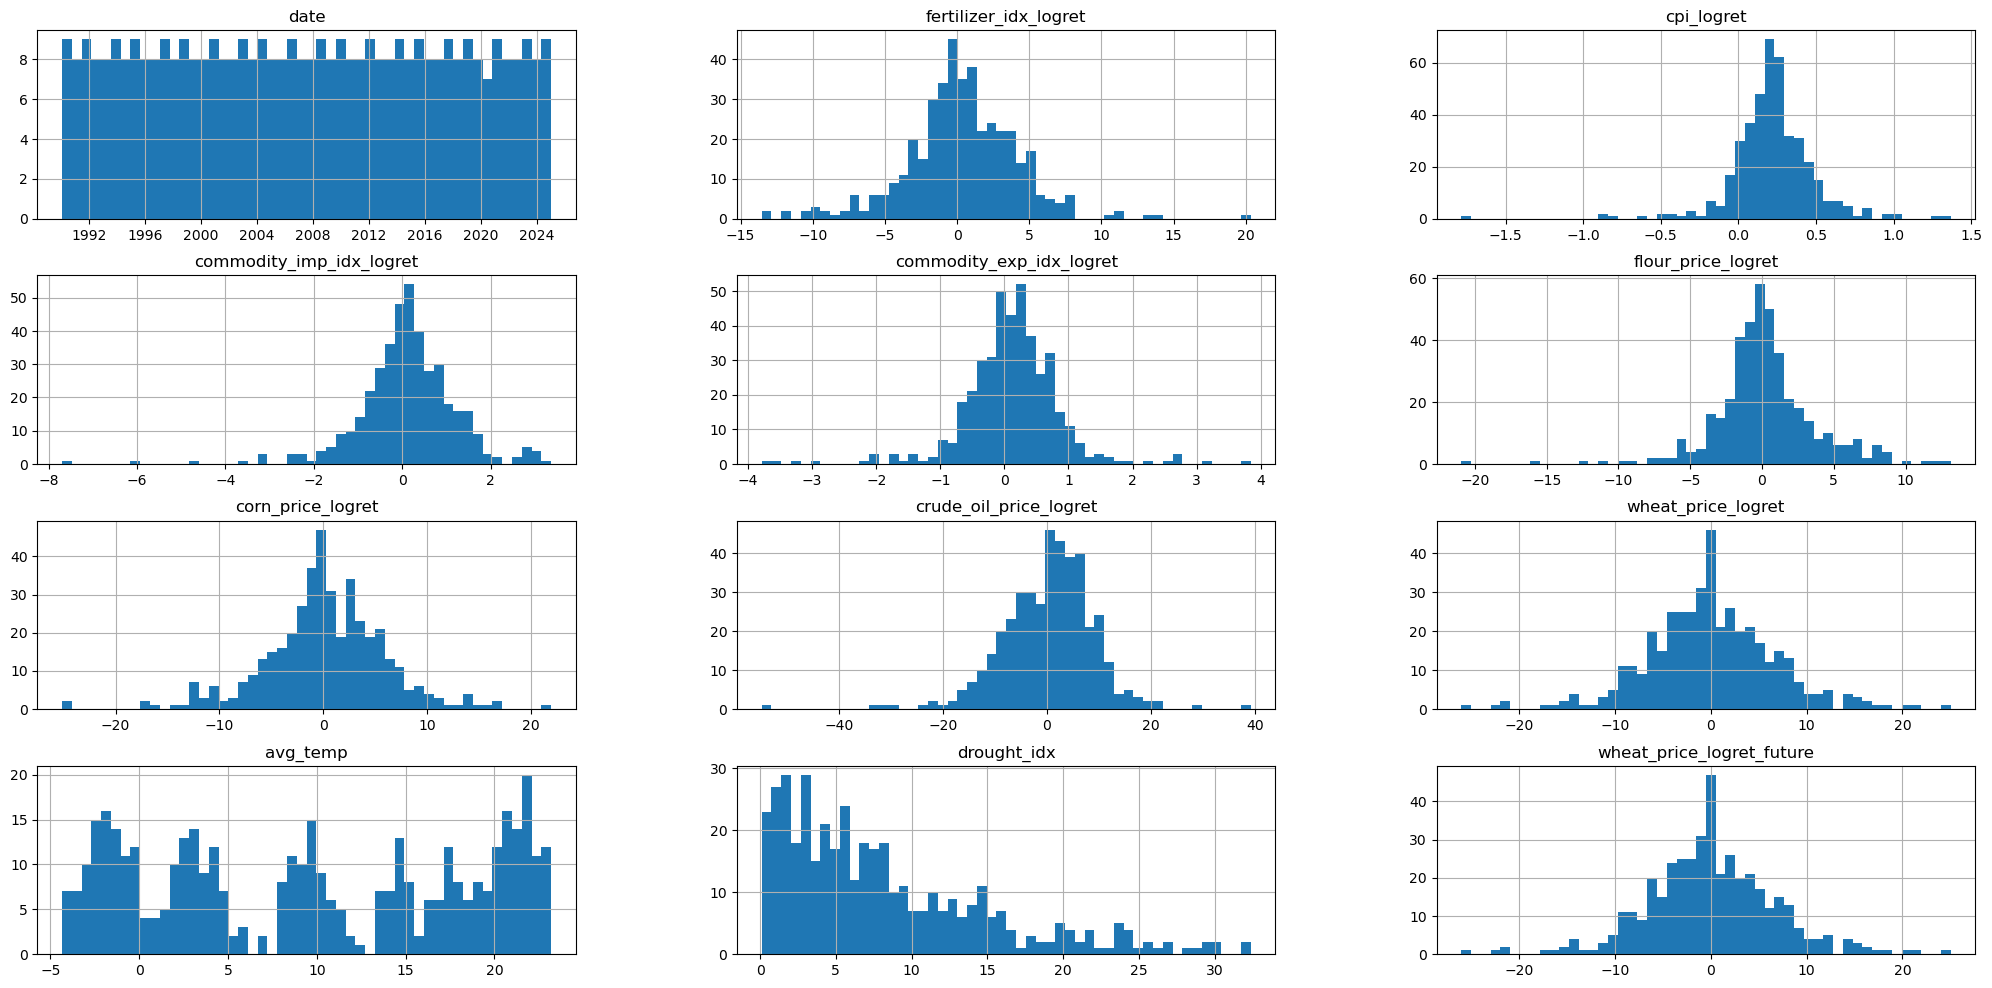

In [7]:
logret_df.hist(bins=50 , figsize=(25, 12))
plt.show()

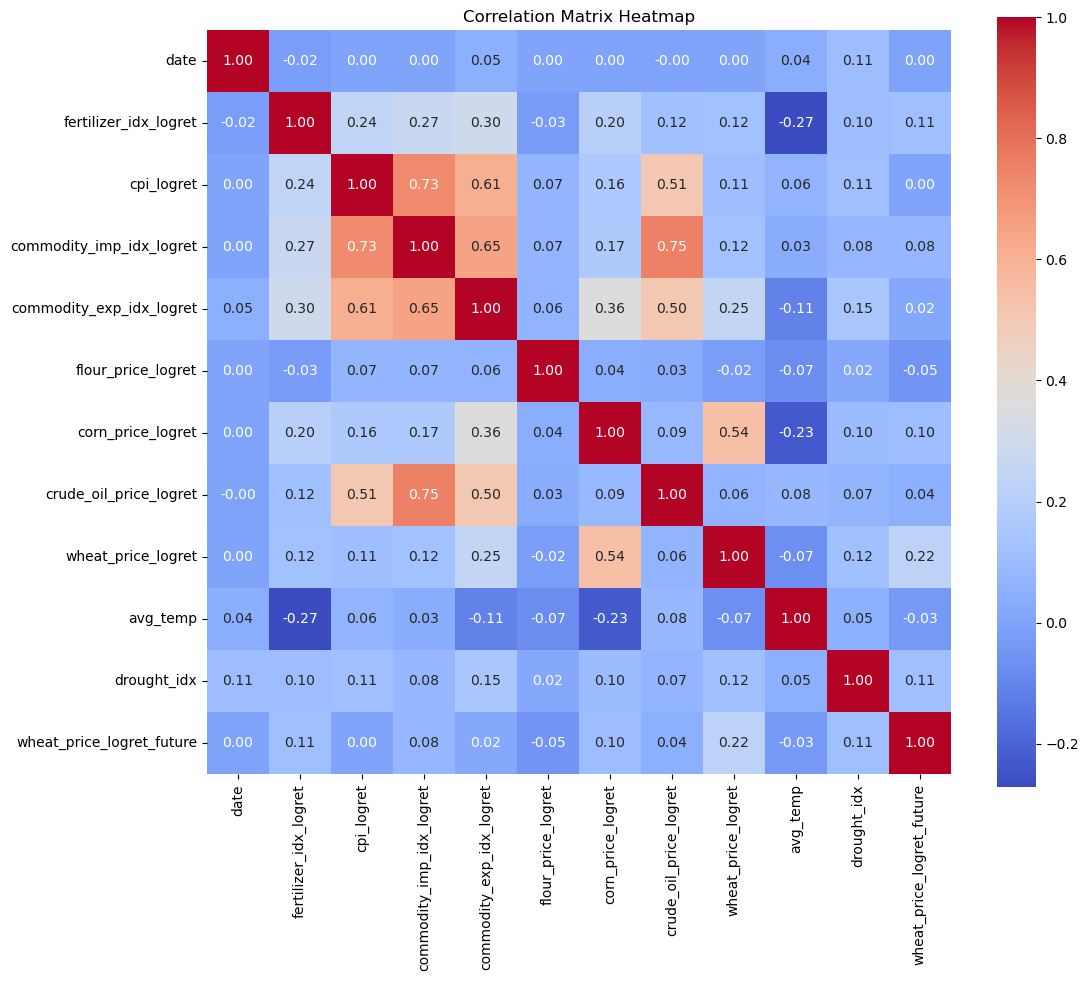

In [8]:
corr_matrix = logret_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

<Figure size 1000x600 with 0 Axes>

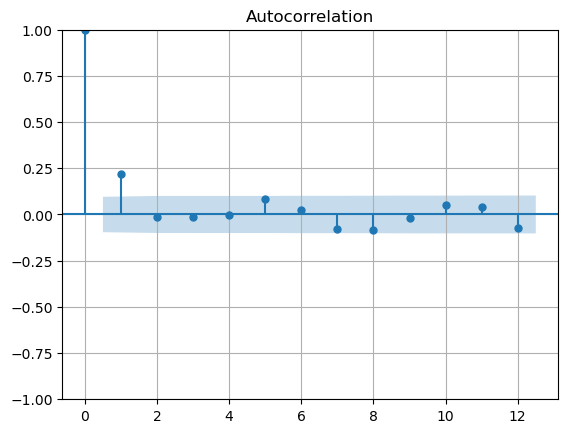

In [9]:
plt.figure(figsize=(10, 6))
plot_acf(logret_df['wheat_price_logret'], lags=12)
plt.grid(True)
plt.show()

In [10]:
logret_df =  logret_df.set_index("date")   

In [11]:
model = AutoReg(logret_df["wheat_price_logret_future"], lags=4, exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()
print(model.summary())

                                AutoReg Model Results                                
Dep. Variable:     wheat_price_logret_future   No. Observations:                  419
Model:                          AutoReg-X(4)   Log Likelihood               -1362.891
Method:                      Conditional MLE   S.D. of innovations              6.457
Date:                       Sat, 10 May 2025   AIC                           2743.781
Time:                               09:40:41   BIC                           2780.036
Sample:                                    4   HQIC                          2758.117
                                         419                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.7357      0.498     -1.478      0.140      -1.711       0.240
wheat_price_logret_fu

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Split into training (1992-2014) and testing (2014 onward)
logret_df_train_data = logret_df.loc[:'2014-01-01']

logret_df_test_data = logret_df.loc['2014-02-01':]


# Fit AutoReg model using training data
model_wheat = AutoReg(logret_df_train_data["wheat_price_logret_future"], lags=4, exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()

# Forecasting
forecast_steps = len(logret_df_test_data)  # Forecast length same as test data

forecast_result = model_wheat.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog_oos = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']])
forecast_result_mean  = forecast_result.predicted_mean  # Point forecasts
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
forecast_result_conf_int = forecast_result.conf_int()
print("Predicted values:\n", forecast_result_mean)
print("Confidence intervals:\n", forecast_result_conf_int)

Predicted values:
 2014-02-01    1.914149
2014-03-01    0.228466
2014-04-01    0.127495
2014-05-01    0.463769
2014-06-01    0.731669
                ...   
2024-08-01   -0.629670
2024-09-01   -0.406049
2024-10-01   -0.434757
2024-11-01    0.208918
2024-12-01    0.096824
Freq: MS, Name: predicted_mean, Length: 131, dtype: float64
Confidence intervals:
                 lower      upper
2014-02-01 -10.625468  14.453767
2014-03-01 -12.814470  13.271401
2014-04-01 -12.921877  13.176867
2014-05-01 -12.586353  13.513891
2014-06-01 -12.319631  13.782968
...               ...        ...
2024-08-01 -13.681178  12.421838
2024-09-01 -13.457557  12.645458
2024-10-01 -13.486264  12.616751
2024-11-01 -12.842589  13.260426
2024-12-01 -12.954684  13.148331

[131 rows x 2 columns]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


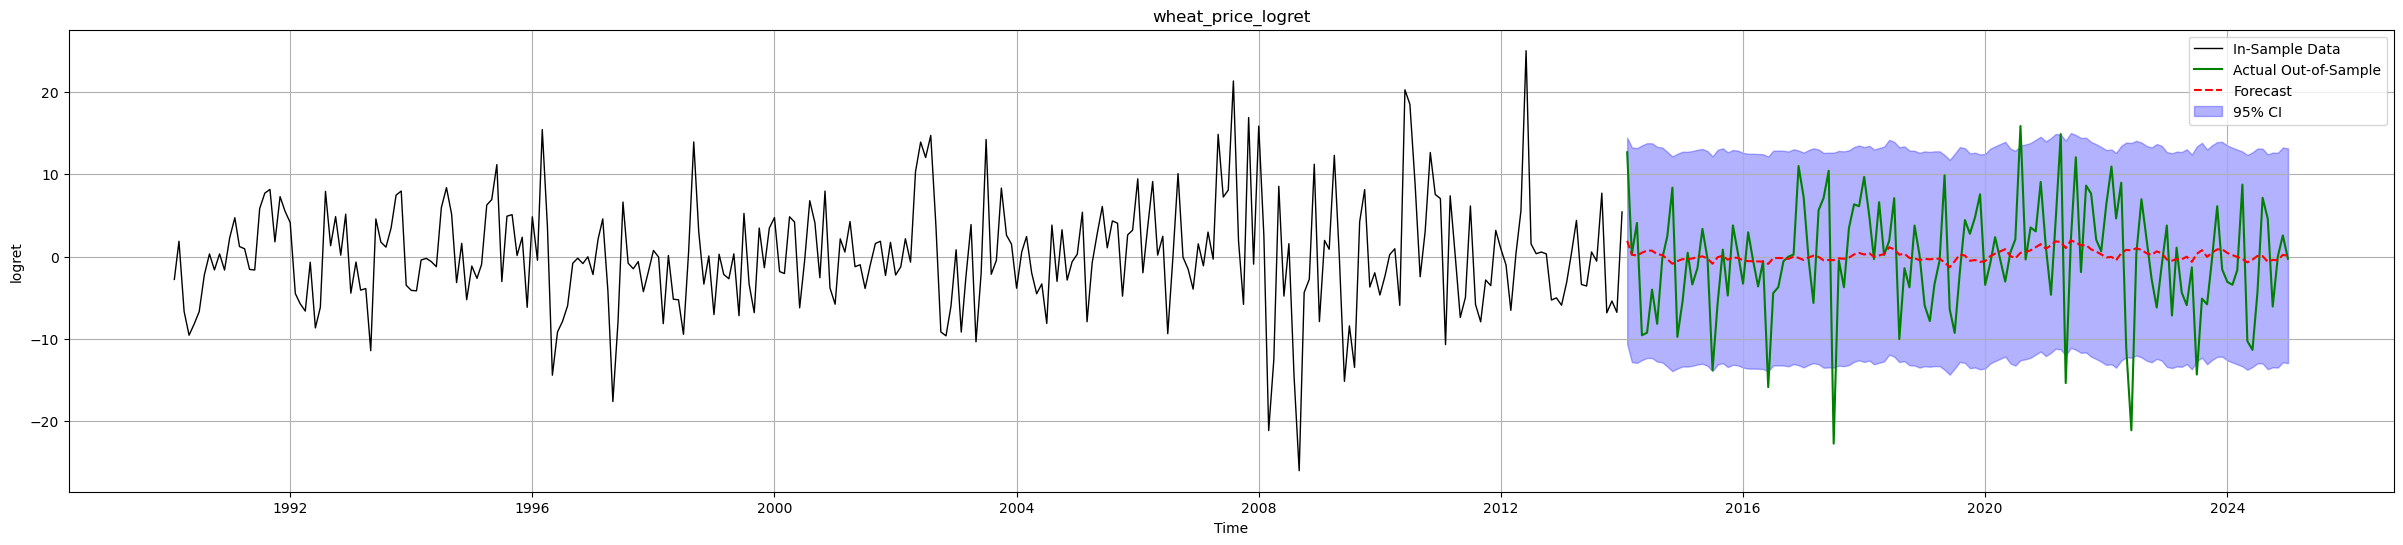

In [13]:
# Plot actual vs forecasted values
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, forecast_result_mean, label="Forecast", color="red", linestyle="dashed")
# Plot confidence intervals
plt.fill_between(logret_df_test_data.index, forecast_result_conf_int.lower, forecast_result_conf_int.upper, color="blue", alpha=0.3, label="95% CI")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [14]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

best_aic = float('inf')
best_order = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                arima_model_wheat = ARIMA(logret_df["wheat_price_logret_future"], order=(p,d,q),
                                          exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()
                if arima_model_wheat.aic < best_aic:
                    best_aic = arima_model_wheat.aic
                    best_order = (p, d, q)
            except:
                continue
                
print(f"Best ARIMA order: {best_order}")
best_arima = ARIMA(logret_df["wheat_price_logret_future"], order = best_order,
                   exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()
print('\n',best_arima.summary())

Best ARIMA order: (1, 0, 2)

                                    SARIMAX Results                                   
Dep. Variable:     wheat_price_logret_future   No. Observations:                  419
Model:                        ARIMA(1, 0, 2)   Log Likelihood               -1370.793
Date:                       Sat, 10 May 2025   AIC                           2757.587
Time:                               09:40:44   BIC                           2789.890
Sample:                                    0   HQIC                          2770.355
                                       - 419                                         
Covariance Type:                         opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.9641      0.377     -2.560      0.010      -1.702      -0.226
corn_price_l

In [15]:
arima_train=ARIMA(logret_df_train_data["wheat_price_logret_future"], order = best_order,
                   exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()
arima_forecast = arima_train.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']])
arima_forecast_result_mean  = arima_forecast.predicted_mean  # Point forecasts
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
arima_forecast_result_conf_int = arima_forecast.conf_int()
print("Predicted values:\n", arima_forecast_result_mean)
print("Confidence intervals:\n", arima_forecast_result_conf_int)

Predicted values:
 2014-02-01    1.854930
2014-03-01   -0.142648
2014-04-01    0.106790
2014-05-01    0.617539
2014-06-01    0.874981
                ...   
2024-08-01   -1.116324
2024-09-01   -0.481289
2024-10-01   -0.654058
2024-11-01    0.315089
2024-12-01   -0.102231
Freq: MS, Name: predicted_mean, Length: 131, dtype: float64
Confidence intervals:
             lower wheat_price_logret_future  upper wheat_price_logret_future
2014-02-01                       -10.645802                        14.355662
2014-03-01                       -13.222129                        12.936832
2014-04-01                       -12.977961                        13.191540
2014-05-01                       -12.467257                        13.702335
2014-06-01                       -12.209815                        13.959777
...                                     ...                              ...
2024-08-01                       -14.201120                        11.968472
2024-09-01                   

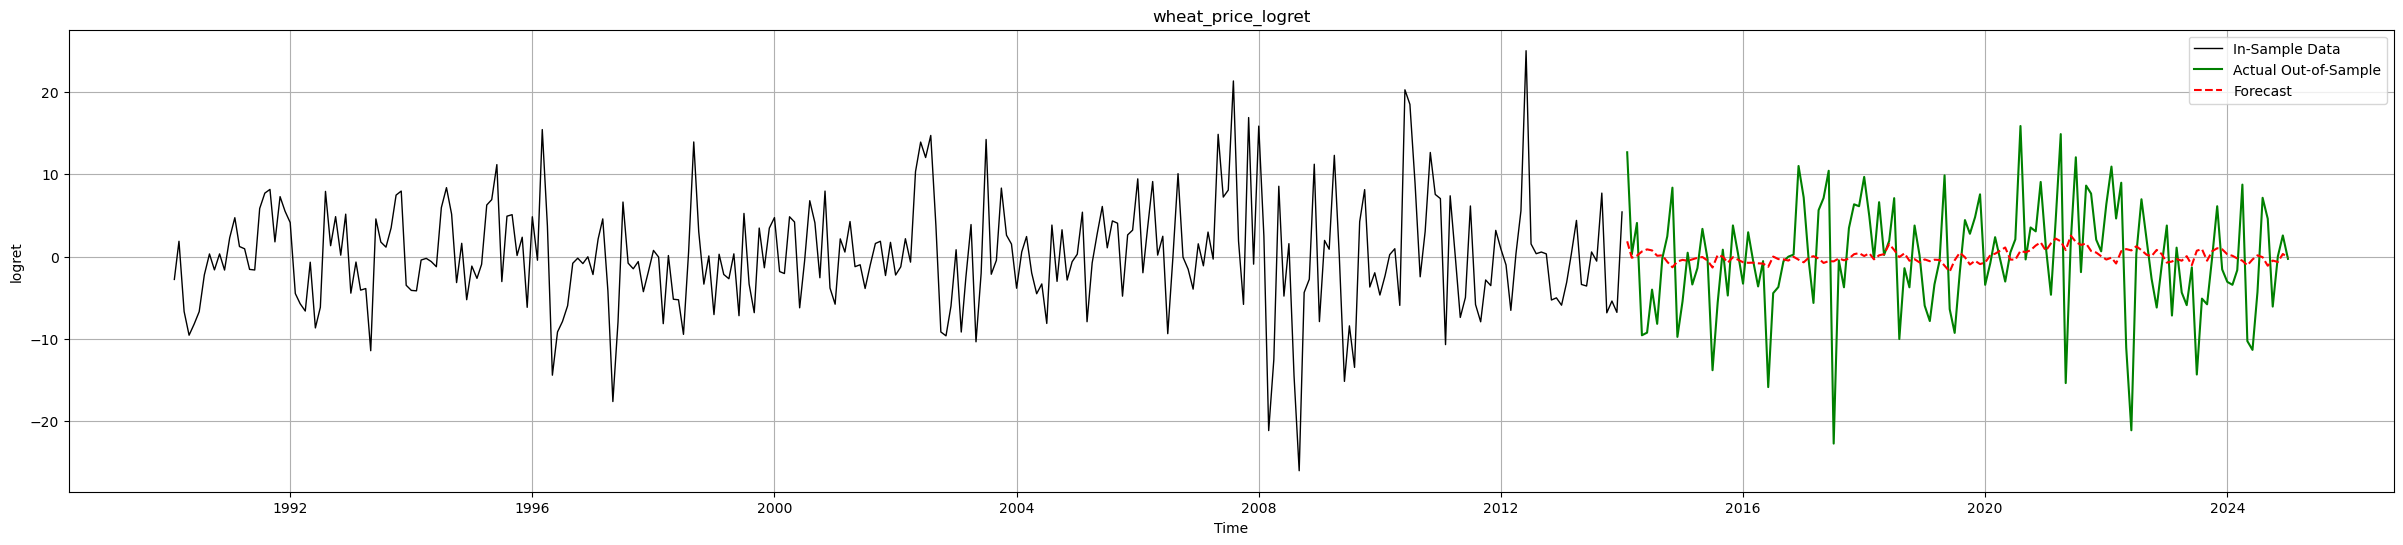

In [16]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, arima_forecast_result_mean, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_aic = float('inf')
best_order = None
best_seasonal = None

for P in range(2):
    for D in range(2):
        for Q in range(2):
            for p in range(3):
                for d in range(2):
                    for q in range(3):
                        try:
                            sarimax_model_wheat = SARIMAX(logret_df["wheat_price_logret_future"], order=(p,d,q),seasonal_order=(P, D, Q, 12),
                                          exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit(disp=False)
                            if sarimax_model_wheat.aic < best_aic:
                                best_aic = sarimax_model_wheat.aic
                                best_order = (p, d, q)
                                best_seasonal = (P,D,Q,12)
                        except:
                            continue

print(f"Best ARIMA order: {best_order}x{best_seasonal}")
best_sarimax = SARIMAX(logret_df["wheat_price_logret"], order = best_order,seasonal_order = best_seasonal,
                   exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()
print('\n',best_sarimax.summary())

Best ARIMA order: (1, 0, 2)x(1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22091D+00    |proj g|=  1.07950D-01


 This problem is unconstrained.



At iterate    5    f=  3.09391D+00    |proj g|=  8.61660D-02

At iterate   10    f=  3.08497D+00    |proj g|=  1.00635D-03

At iterate   15    f=  3.08482D+00    |proj g|=  5.96168D-03

At iterate   20    f=  3.08475D+00    |proj g|=  1.04894D-03

At iterate   25    f=  3.08460D+00    |proj g|=  1.66877D-02

At iterate   30    f=  3.08376D+00    |proj g|=  4.26507D-03

At iterate   35    f=  3.08359D+00    |proj g|=  1.88093D-04

At iterate   40    f=  3.08359D+00    |proj g|=  1.74257D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     48      1     0     0   4.286D-06   3.084D+00
  F =   3.08358539829

In [18]:
sarimax_train=SARIMAX(logret_df_train_data["wheat_price_logret_future"], order = best_order,seasonal_order = best_seasonal,
                   exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit(disp=False)
sarimax_forecast = sarimax_train.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']])
sarimax_forecast_result_mean  = sarimax_forecast.predicted_mean
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
sarimax_forecast_result_conf_int = sarimax_forecast.conf_int()
print("Predicted values:\n", sarimax_forecast_result_mean)
print("Confidence intervals:\n", sarimax_forecast_result_conf_int)

Predicted values:
 2014-02-01    1.400019
2014-03-01   -0.688468
2014-04-01    0.452681
2014-05-01   -0.416759
2014-06-01    1.215026
                ...   
2024-08-01    0.684805
2024-09-01    0.586507
2024-10-01   -0.550755
2024-11-01    1.345419
2024-12-01   -0.121136
Freq: MS, Name: predicted_mean, Length: 131, dtype: float64
Confidence intervals:
             lower wheat_price_logret_future  upper wheat_price_logret_future
2014-02-01                       -11.245973                        14.046011
2014-03-01                       -13.769797                        12.392860
2014-04-01                       -12.640063                        13.545426
2014-05-01                       -13.519939                        12.686422
2014-06-01                       -11.897692                        14.327745
...                                     ...                              ...
2024-08-01                       -12.573059                        13.942669
2024-09-01                   

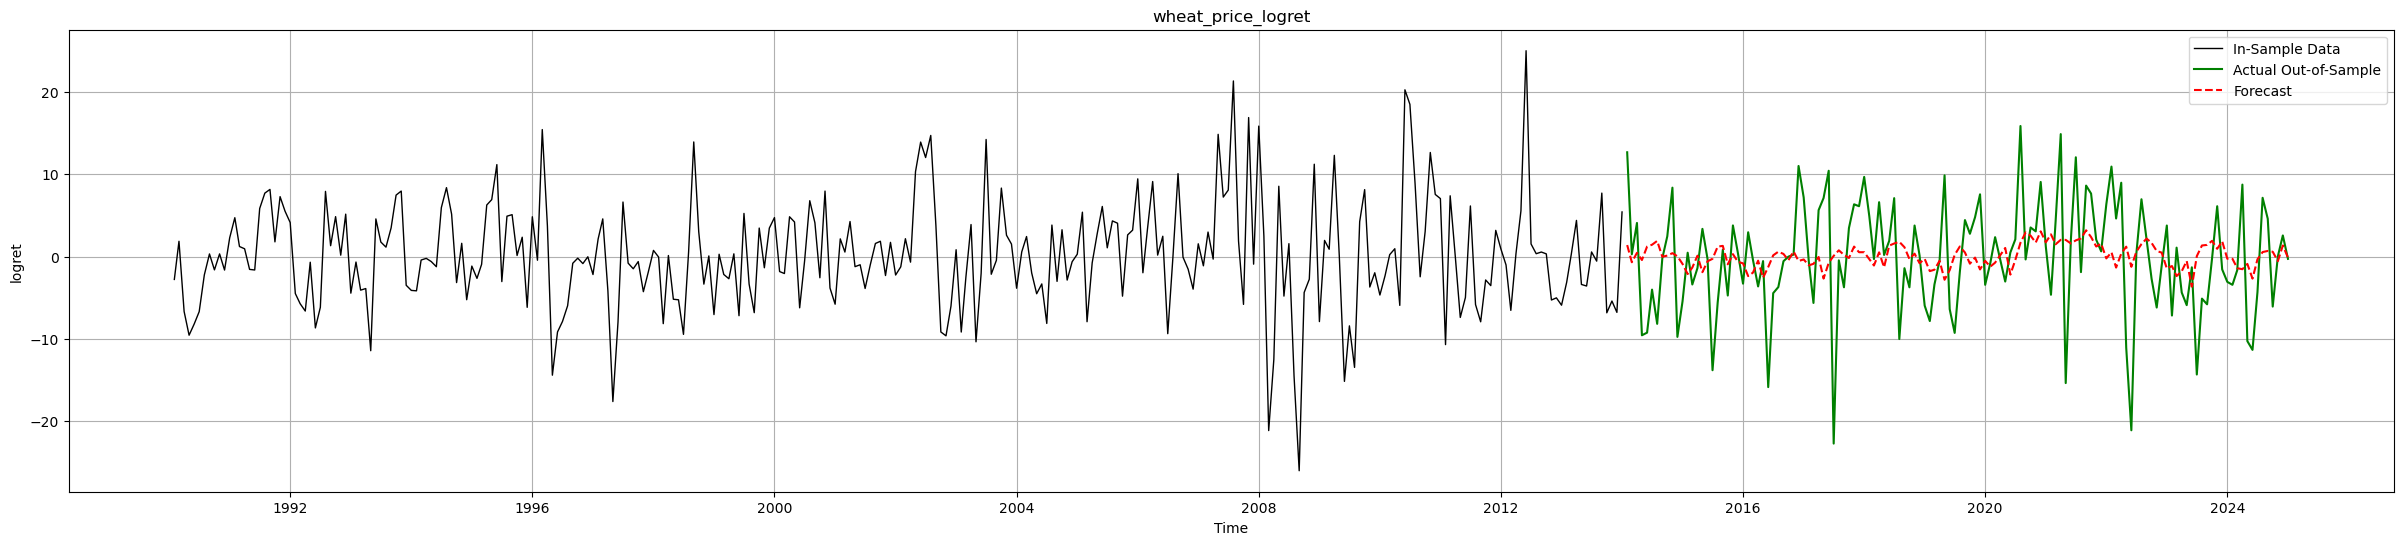

In [19]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, sarimax_forecast_result_mean, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [20]:
# Primary variables with multiple lags
primary_vars = ['wheat_price_logret', 'corn_price_logret', 'drought_idx']
primary_lags = [1, 2, 3, 6, 12]  # More comprehensive lag structure

# Secondary variables with fewer lags
secondary_vars = ['fertilizer_idx_logret', 'crude_oil_price_logret', 'flour_price_logret']
secondary_lags = [1, 3, 6]

df_lagged = logret_df.copy()

# Create lags for primary variables
for var in primary_vars:
    for lag in primary_lags:
        df_lagged[f'{var}_lag_{lag}'] = df_lagged[var].shift(lag)

# Create lags for secondary variables
for var in secondary_vars:
    for lag in secondary_lags:
        df_lagged[f'{var}_lag_{lag}'] = df_lagged[var].shift(lag)

# Drop rows with NaN values (due to lagging)
df_lagged = df_lagged.dropna()

df_lagged

,fertilizer_idx_logret,cpi_logret,commodity_imp_idx_logret,commodity_exp_idx_logret,flour_price_logret,corn_price_logret,crude_oil_price_logret,wheat_price_logret,avg_temp,drought_idx,...,drought_idx_lag_12,fertilizer_idx_logret_lag_1,fertilizer_idx_logret_lag_3,fertilizer_idx_logret_lag_6,crude_oil_price_logret_lag_1,crude_oil_price_logret_lag_3,crude_oil_price_logret_lag_6,flour_price_logret_lag_1,flour_price_logret_lag_3,flour_price_logret_lag_6
date,,,,,,,,,,,,,,,,,,,,,
1991-02-01,0.076132,0.074212,-2.083409,-0.103359,-3.758271,0.743488,-20.858496,2.283945,0.704926,15.7,...,14.6,0.611155,2.179075,1.665975,-7.812007,-10.863384,39.218856,3.333642,-3.758271,-1.941809
1991-03-01,-0.687288,0.000000,0.000000,-0.310720,0.000000,2.559569,-2.872907,4.725289,3.273592,8.2,...,11.2,0.076132,0.460830,5.415875,-20.858496,-16.984176,20.459097,-3.758271,0.424629,-2.381065
1991-04-01,-1.700196,0.222305,-0.845671,0.207254,0.847463,1.077216,4.567452,1.223253,9.166041,3.8,...,8.0,-0.687288,0.611155,4.588330,-2.872907,-7.812007,7.278553,0.000000,3.333642,-2.028467
1991-05-01,-1.808936,0.369413,-0.212540,-0.207254,-0.847463,-4.164077,1.902102,0.946878,14.906199,1.8,...,7.1,-1.700196,0.076132,2.179075,4.567452,-20.858496,-10.863384,0.847463,-3.758271,-3.758271
1991-06-01,-1.923136,0.294551,-0.640344,-0.311689,0.847463,-0.590023,-5.022784,-1.556634,19.369806,1.4,...,7.3,-1.808936,-0.687288,0.460830,1.902102,-2.872907,-16.984176,-0.847463,0.000000,0.424629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,-0.640598,0.228941,-0.354233,-0.609139,-0.174368,8.141046,-8.772297,7.142700,18.204330,2.7,...,8.6,-1.605765,-4.208302,3.622074,-6.463633,-0.312911,5.085307,0.000000,0.873368,1.246677
2024-10-01,3.456237,0.226200,0.141844,1.013180,-1.229164,3.178930,2.460927,4.596432,12.209506,2.9,...,9.2,-0.640598,-1.078639,1.293346,-8.772297,2.512975,4.886047,-0.174368,-0.174064,1.580367
2024-11-01,-0.544440,0.280058,0.141643,0.000000,-2.504603,5.998462,-2.874652,-6.077022,4.312016,5.7,...,11.4,3.456237,-1.605765,-1.278942,2.460927,-6.463633,-6.448385,-1.229164,0.000000,-0.699304


In [21]:
lagged_df_train = logret_df.loc[:'2014-01-01']

lagged_df_test = logret_df.loc['2014-02-01':]

X_train = lagged_df_train.drop(columns='wheat_price_logret_future')
X_test = lagged_df_test.drop(columns='wheat_price_logret_future')
y_train = lagged_df_train['wheat_price_logret_future']
y_test = lagged_df_test['wheat_price_logret_future']

In [22]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [23]:
dt_forecast = dt_model.predict(X_test)
dt_forecast_series = pd.Series(dt_forecast, index=X_test.index, name='forecast')


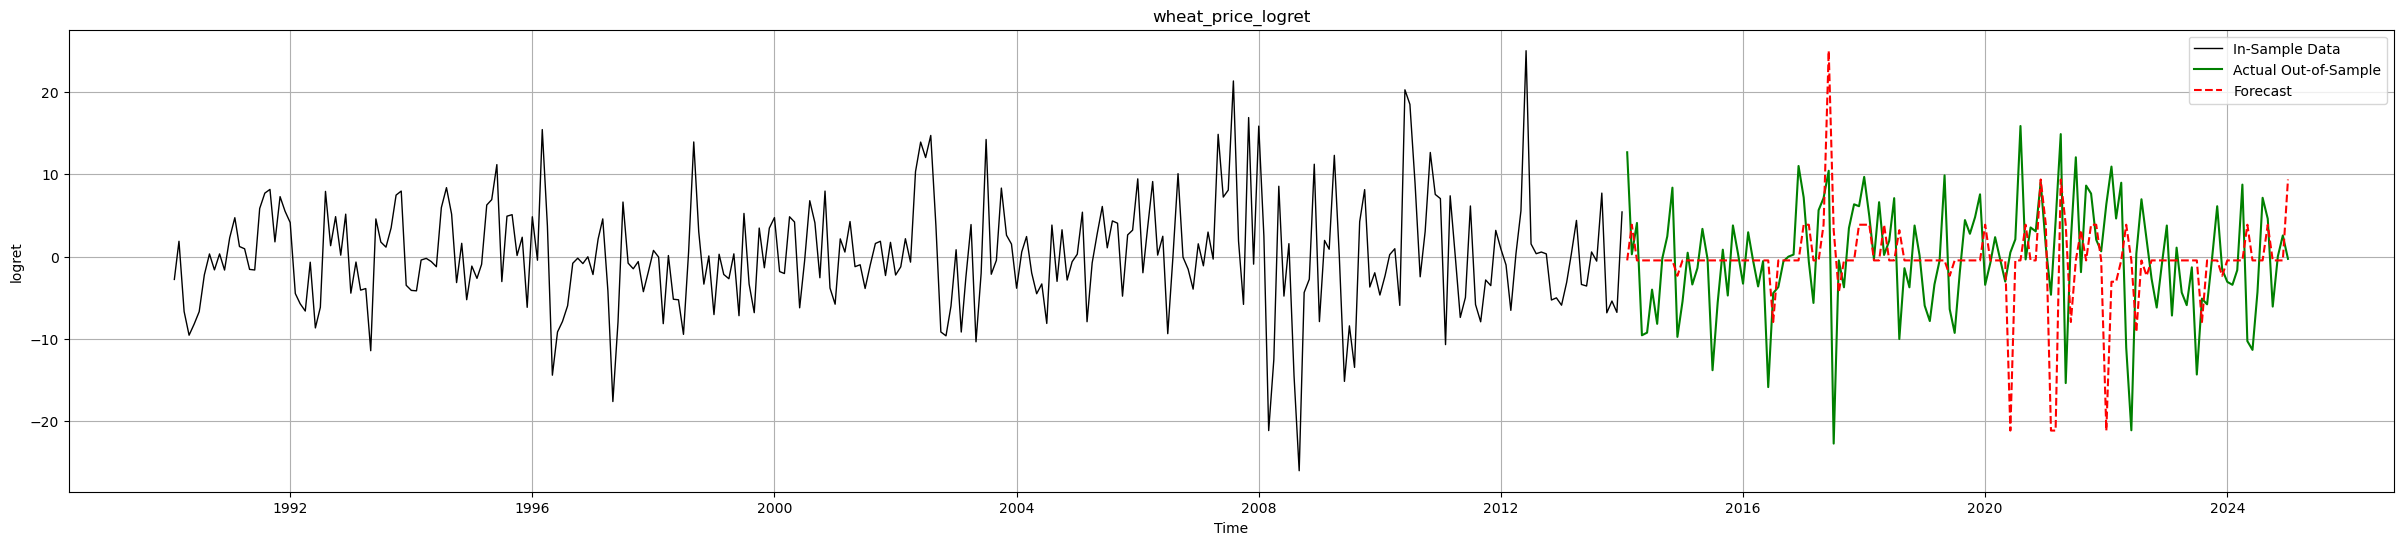

In [24]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, dt_forecast_series, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    cv=tscv,                           # Time series cross-validation
    verbose=1,
    n_jobs=-1                          # Use all available cores
).fit(X_train,y_train)

# Perform grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [26]:
best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)
best_xgb.fit(X_train, y_train)

# Make predictions
xgb_forecast = best_xgb.predict(X_test)

# Create a Series with the forecast results and the same index as test_data
xgb_forecast_series = pd.Series(xgb_forecast, index=X_test.index, name='forecast')

In [27]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(feature_importance)


Top 10 Most Important Features:
                    Feature  Importance
7        wheat_price_logret    0.187502
8                  avg_temp    0.150954
2  commodity_imp_idx_logret    0.129540
9               drought_idx    0.123557
3  commodity_exp_idx_logret    0.113159
6    crude_oil_price_logret    0.107628
5         corn_price_logret    0.078645
4        flour_price_logret    0.067774
1                cpi_logret    0.026296
0     fertilizer_idx_logret    0.014946


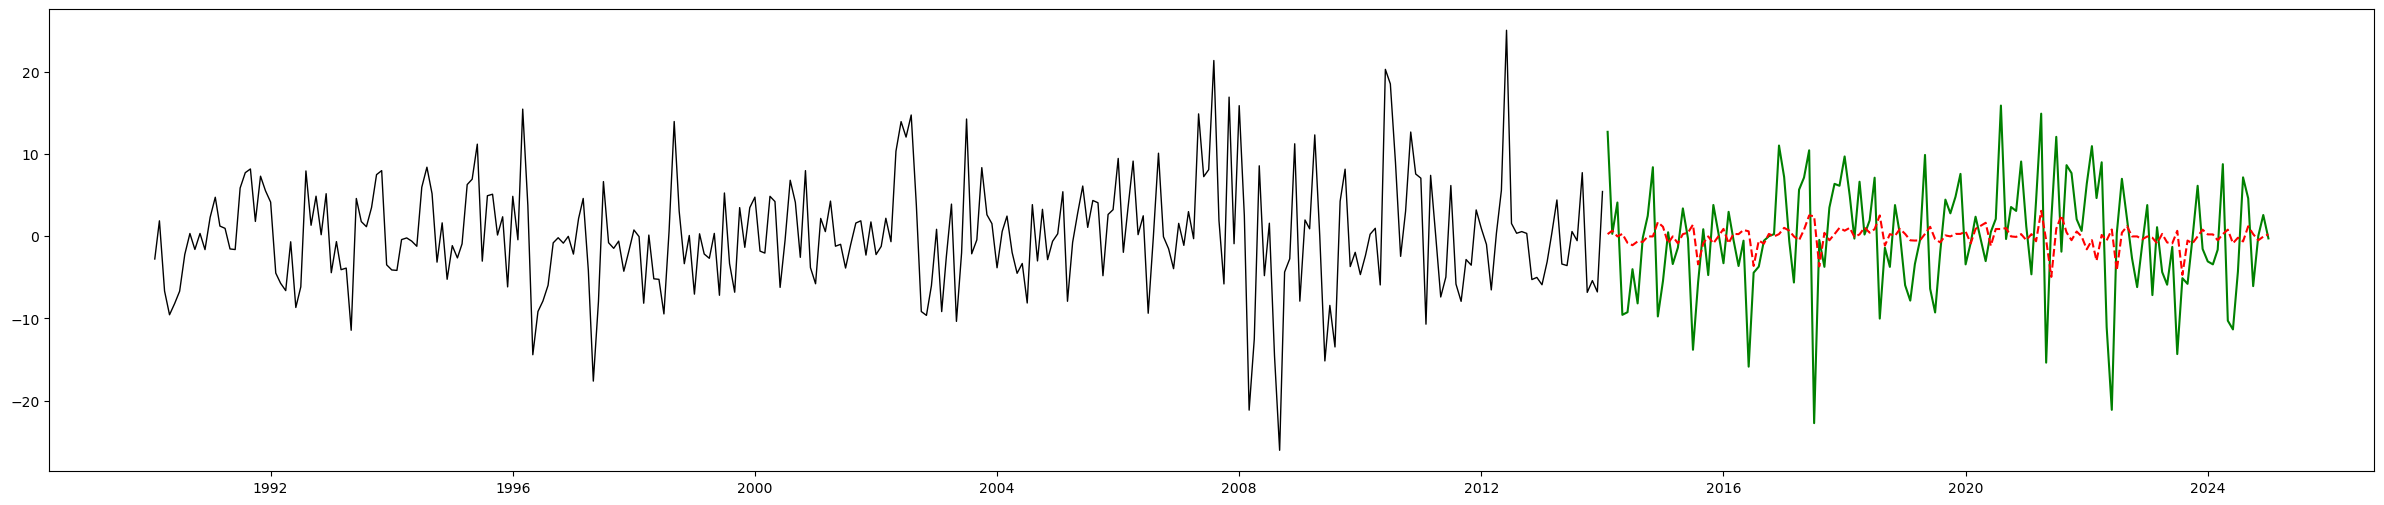

In [28]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, xgb_forecast_series, label="Forecast", color="red", linestyle="dashed")


In [29]:
actual_values = logret_df_test_data["wheat_price_logret_future"]
forecasts = {
    'AutoReg': forecast_result_mean,
    'ARIMA': arima_forecast_result_mean,
    'SARIMAX': sarimax_forecast_result_mean,
    'Decision Tree': dt_forecast_series,
    'XGBoost': xgb_forecast_series
}

# Calculate metrics
results = []
for model_name, predicted_values in forecasts.items():
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predicted_values)
    
    results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })
results_df = pd.DataFrame(results).sort_values('RMSE')
results_df

,Model,MSE,RMSE,MAE
0,AutoReg,44.756439,6.690025,5.052379
1,ARIMA,44.866122,6.698218,5.078563
2,SARIMAX,45.439390,6.740875,5.184271
4,XGBoost,47.158373,6.867195,5.207292
3,Decision Tree,66.404748,8.148911,5.946215
